In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import pandas as pd


# PRE REQUISITES

In [2]:
vids = sorted(os.listdir("/home/ubuntu/data/HAR_datasets/GTEA/png"))


In [3]:
# How many frames does the dataset have

frames = 0
for vid in vids:
    frames += len(os.listdir("/home/ubuntu/data/HAR_datasets/GTEA/png/"+vid))
frames

31225

## Rename all hands and move them to train/val dataset

Rename the frames as vid+frame.png

Move them into the train and val folder

~/local/ssd_colab/GTEA_feats/one_image_per_frame   
(venv) ❯ mv *S2* /home/ubuntu/local/Resnet50/GTEA/train

Now, we have a train folder with all frames of person 1,2,3. The val is done on the frames of the videos of person 4.

In [4]:
dir = "/home/ubuntu/local/ssd_colab/GTEA_feats/one_image_per_frame/"
for v in vids:
    for file in sorted(os.listdir(dir+v)):
        old_name = os.path.join(dir, v, file)
        new_base = v + "_" + file
        new_name = os.path.join(dir, new_base)
        os.rename(old_name, new_name)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/local/ssd_colab/GTEA_feats/one_image_per_frame/S1_Cheese_C1'

## Create annotation csv

There are 2 files, one for training and one for validation
Each contain the path to the frame and the action label in int

In [5]:
# Map action label and their int label

mapping_file = "/home/ubuntu/data/HAR_datasets/GTEA/labels/mapping.txt"
file_ptr = open(mapping_file, 'r')
actions = file_ptr.read().split('\n')[:-1]
file_ptr.close()
actions_dict = dict()
for a in actions:
    actions_dict[a.split()[1]] = int(a.split()[0])
actions_dict

{'background_action': 0,
 'close_chocolate': 1,
 'close_coffee': 2,
 'close_honey': 3,
 'close_jam': 4,
 'close_ketchup': 5,
 'close_mayonnaise': 6,
 'close_mustard': 7,
 'close_peanut': 8,
 'close_sugar': 9,
 'close_water': 10,
 'fold_bread': 11,
 'open_cheese': 12,
 'open_chocolate': 13,
 'open_coffee': 14,
 'open_honey': 15,
 'open_jam': 16,
 'open_ketchup': 17,
 'open_mayonnaise': 18,
 'open_mustard': 19,
 'open_peanut': 20,
 'open_sugar': 21,
 'open_tea': 22,
 'open_water': 23,
 'pour_chocolate_bread': 24,
 'pour_coffee_spoon_cup': 25,
 'pour_honey_bread': 26,
 'pour_honey_cup': 27,
 'pour_ketchup_hotdog_bread': 28,
 'pour_mayonnaise_cheese_bread': 29,
 'pour_mustard_cheese_bread': 30,
 'pour_mustard_hotdog_bread': 31,
 'pour_sugar_spoon_cup': 32,
 'pour_water_cup': 33,
 'put_bread_bread': 34,
 'put_bread_cheese_bread': 35,
 'put_cheese_bread': 36,
 'put_chocolate': 37,
 'put_coffee': 38,
 'put_honey': 39,
 'put_hotdog_bread': 40,
 'put_jam': 41,
 'put_ketchup': 42,
 'put_mayonnai

In [6]:
v = vids[0]
frames = sorted([filename for filename in os.listdir('/home/ubuntu/local/Resnet50/GTEA/train') if filename.startswith(v)])

df = pd.read_csv("/home/ubuntu/data/HAR_datasets/GTEA/labels/final_labels_csv/"+v+".csv")
df["frame_path"] = frames
df["label"] = df["action"].map(actions_dict)
df = df[["frame_path", "label"]]
df

,frame_path,label
0,S1_Cheese_C1_0000000001.png,0
1,S1_Cheese_C1_0000000002.png,0
2,S1_Cheese_C1_0000000003.png,0
3,S1_Cheese_C1_0000000004.png,0
4,S1_Cheese_C1_0000000005.png,0
...,...,...
938,S1_Cheese_C1_0000000939.png,0
939,S1_Cheese_C1_0000000940.png,0
940,S1_Cheese_C1_0000000941.png,0
941,S1_Cheese_C1_0000000942.png,0


In [9]:
df_final = pd.DataFrame()
vids = sorted(os.listdir("/home/ubuntu/data/HAR_datasets/GTEA/png"))
v0 = vids[0]
frames = sorted([filename for filename in os.listdir('/home/ubuntu/local/Resnet50/GTEA/train') if filename.startswith(v0)])

df = pd.read_csv("/home/ubuntu/data/HAR_datasets/GTEA/labels/final_labels_csv/"+v0+".csv")
df["frame_path"] = frames
df["label"] = df["action"].map(actions_dict)
df = df[["frame_path", "label"]]

df_final = [df_final, df]
df_train = pd.concat(df_final)

for vid in vids[1:21]:
    print(vid)
    frames = sorted([filename for filename in os.listdir('/home/ubuntu/local/Resnet50/GTEA/train') if filename.startswith(vid)])

    df = pd.read_csv("/home/ubuntu/data/HAR_datasets/GTEA/labels/final_labels_csv/"+vid+".csv")
    df["frame_path"] = frames
    df["label"] = df["action"].map(actions_dict)
    df = df[["frame_path", "label"]]

    df_final = [df_train, df]
    df_train = pd.concat(df_final)
df_train.to_csv("/home/ubuntu/local/Resnet50/csv/noun/train.csv", index=False)

S1_CofHoney_C1
S1_Coffee_C1
S1_Hotdog_C1
S1_Pealate_C1
S1_Peanut_C1
S1_Tea_C1
S2_Cheese_C1
S2_CofHoney_C1
S2_Coffee_C1
S2_Hotdog_C1
S2_Pealate_C1
S2_Peanut_C1
S2_Tea_C1
S3_Cheese_C1
S3_CofHoney_C1
S3_Coffee_C1
S3_Hotdog_C1
S3_Pealate_C1
S3_Peanut_C1
S3_Tea_C1


In [31]:
df_final = pd.DataFrame()

vids = sorted([filename for filename in os.listdir("/home/ubuntu/data/HAR_datasets/GTEA/png") if filename.startswith('S1')])
v0 = vids[0]
frames = sorted([filename for filename in os.listdir('/home/ubuntu/local/Resnet50/GTEA/train') if filename.startswith(v0)])
frames

df = pd.read_csv("/home/ubuntu/data/hierarchical_train/data/noun/"+v0+".txt", header=None)
df.columns = ["action"]
df["frame_path"] = frames
df["label"] = df["action"].map(actions_dict)
df = df[["frame_path", "label"]]
df
df_final = [df_final, df]
df_val = pd.concat(df_final)

for vid in vids[1:]:
    print(vid)
    frames = sorted([filename for filename in os.listdir('/home/ubuntu/local/Resnet50/GTEA/train') if filename.startswith(vid)])

    df = pd.read_csv("/home/ubuntu/data/hierarchical_train/data/noun/"+vid+".txt", header=None)
    df.columns = ["action"]
    df["frame_path"] = frames
    df["label"] = df["action"].map(actions_dict)
    df = df[["frame_path", "label"]]

    df_final = [df_val, df]
    df_val = pd.concat(df_final)
df_val
df_val.to_csv("/home/ubuntu/local/Resnet50/csv/noun/split1/test.csv", index=False)

S1_CofHoney_C1
S1_Coffee_C1
S1_Hotdog_C1
S1_Pealate_C1
S1_Peanut_C1
S1_Tea_C1


In [39]:
# Check correct number of files
len(df_train) + len(df_val)

31225

### Do the same for noun annotation

In [13]:
# Map action label and their int label

mapping_file = "/home/ubuntu/data/hierarchical_train/data/Nmapping.txt"
file_ptr = open(mapping_file, 'r')
actions = file_ptr.read().split('\n')
file_ptr.close()
actions_dict = dict()
for a in actions:
    actions_dict[a.split()[1]] = int(a.split()[0])
actions_dict

{'action': 0,
 'bread': 1,
 'bread_bread': 2,
 'bread_cheese_bread': 3,
 'cheese': 4,
 'cheese_bread': 5,
 'chocolate': 6,
 'chocolate_bread': 7,
 'coffee': 8,
 'coffee_spoon': 9,
 'coffee_spoon_cup': 10,
 'cup': 11,
 'honey': 12,
 'honey_bread': 13,
 'honey_cup': 14,
 'hotdog': 15,
 'hotdog_bread': 16,
 'jam': 17,
 'jam_spoon': 18,
 'jam_spoon_bread': 19,
 'ketchup': 20,
 'ketchup_hotdog_bread': 21,
 'mayonnaise': 22,
 'mayonnaise_cheese_bread': 23,
 'mustard': 24,
 'mustard_cheese_bread': 25,
 'mustard_hotdog_bread': 26,
 'peanut': 27,
 'peanut_spoon': 28,
 'peanut_spoon_bread': 29,
 'spoon': 30,
 'spoon_cup': 31,
 'sugar': 32,
 'sugar_spoon': 33,
 'sugar_spoon_cup': 34,
 'tea': 35,
 'tea_cup': 36,
 'water': 37,
 'water_cup': 38}

In [113]:
v = "S1_CofHoney_C1"
frames = sorted([filename for filename in os.listdir('/home/ubuntu/local/Resnet50/GTEA/train') if filename.startswith(v)])

df = pd.read_csv("/home/ubuntu/data/hierarchical_train/data/noun/"+v+".txt", header=None)
df.columns = [["lab"]]
ser = df.iloc[:,0] #df["lab"] into a serie
print(ser)

df["frame_path"] = frames
df["label"] = ser.map(actions_dict)
df = df[["frame_path", "label"]]
df.dtypes

0       action
1       action
2       action
3       action
4       action
         ...  
1230    action
1231    action
1232    action
1233    action
1234    action
Name: (lab,), Length: 1235, dtype: object


frame_path    object
label          int64
dtype: object

In [99]:
df.dtypes

frame_path    object
label          int64
dtype: object

In [14]:
df_final = pd.DataFrame()

v0 = vids[0]
frames = sorted([filename for filename in os.listdir('/home/ubuntu/local/Resnet50/GTEA/train') if filename.startswith(v0)])

df = pd.read_csv("/home/ubuntu/data/hierarchical_train/data/noun/"+v0+".txt", header=None)
df.columns = [["lab"]]
ser = df.iloc[:,0] #df["lab"] into a serie
df["frame_path"] = frames
df["label"] = ser.map(actions_dict)
df = df[["frame_path", "label"]]
df_final = [df_final, df]
df_train = pd.concat(df_final)

for vid in vids[1:21]:
    print(vid)
    frames = sorted([filename for filename in os.listdir('/home/ubuntu/local/Resnet50/GTEA/train') if filename.startswith(vid)])

    df = pd.read_csv("/home/ubuntu/data/hierarchical_train/data/noun/"+vid+".txt", header=None)
    df.columns = [["lab"]]
    ser = df.iloc[:,0] #df["lab"] into a serie
    df["frame_path"] = frames
    df["label"] = ser.map(actions_dict)
    df["label"] = df["label"].astype(int)
    df = df[["frame_path", "label"]]
    df_final = [df_train, df]
    df_train = pd.concat(df_final)
    

df_train.to_csv("/home/ubuntu/local/Resnet50/csv/noun/train.csv", index=False)

S1_CofHoney_C1
S1_Coffee_C1
S1_Hotdog_C1
S1_Pealate_C1
S1_Peanut_C1
S1_Tea_C1
S2_Cheese_C1
S2_CofHoney_C1
S2_Coffee_C1
S2_Hotdog_C1
S2_Pealate_C1
S2_Peanut_C1
S2_Tea_C1
S3_Cheese_C1
S3_CofHoney_C1
S3_Coffee_C1
S3_Hotdog_C1
S3_Pealate_C1
S3_Peanut_C1
S3_Tea_C1


In [117]:
df_final = pd.DataFrame()

vids = sorted([filename for filename in os.listdir("/home/ubuntu/data/HAR_datasets/GTEA/png") if filename.startswith('S4')])
v0 = vids[0]
frames = sorted([filename for filename in os.listdir('/home/ubuntu/local/Resnet50/GTEA/val') if filename.startswith(v0)])

df = pd.read_csv("/home/ubuntu/data/hierarchical_train/data/noun/"+v0+".txt", header=None)
df.columns = [["lab"]]
ser = df.iloc[:,0] #df["lab"] into a serie
df["frame_path"] = frames
df["label"] = ser.map(actions_dict)
df = df[["frame_path", "label"]]
df_final = [df_final, df]
df_train = pd.concat(df_final)

for vid in vids[1:21]:
    print(vid)
    frames = sorted([filename for filename in os.listdir('/home/ubuntu/local/Resnet50/GTEA/val') if filename.startswith(vid)])

    df = pd.read_csv("/home/ubuntu/data/hierarchical_train/data/noun/"+vid+".txt", header=None)
    df.columns = [["lab"]]
    ser = df.iloc[:,0] #df["lab"] into a serie
    df["frame_path"] = frames
    df["label"] = ser.map(actions_dict)
    df["label"] = df["label"].astype(int)
    df = df[["frame_path", "label"]]
    df_final = [df_train, df]
    df_train = pd.concat(df_final)
    

df_train.to_csv("/home/ubuntu/local/Resnet50/csv/noun/val.csv", index=False)

S4_CofHoney_C1
S4_Coffee_C1
S4_Hotdog_C1
S4_Pealate_C1
S4_Peanut_C1
S4_Tea_C1


## Do the same for verbs

In [2]:
# Map action label and their int label

mapping_file = "/home/ubuntu/data/hierarchical_train/data/Vmapping.txt"
file_ptr = open(mapping_file, 'r')
actions = file_ptr.read().split('\n')
file_ptr.close()
actions_dict = dict()
for a in actions:
    actions_dict[a.split()[1]] = int(a.split()[0])
actions_dict

{'take': 0,
 'open': 1,
 'pour': 2,
 'close': 3,
 'shake': 4,
 'scoop': 5,
 'stir': 6,
 'put': 7,
 'fold': 8,
 'spread': 9,
 'background': 10}

In [7]:
v = "S1_Cheese_C1"
frames = sorted([filename for filename in os.listdir('/home/ubuntu/local/Resnet50/GTEA/train') if filename.startswith(v)])

df = pd.read_csv("/home/ubuntu/data/hierarchical_train/data/verb/"+v+".txt", header=None)
df.columns = [["lab"]]
ser = df.iloc[:,0] #df["lab"] into a serie
print(ser)

df["frame_path"] = frames
df["label"] = ser.map(actions_dict)
df = df[["frame_path", "label"]]
df.dtypes

0      background
1      background
2      background
3      background
4      background
          ...    
938    background
939    background
940    background
941    background
942    background
Name: (lab,), Length: 943, dtype: object


frame_path    object
label          int64
dtype: object

In [10]:
df_final = pd.DataFrame()
vids = sorted(os.listdir("/home/ubuntu/data/HAR_datasets/GTEA/png"))
v0 = vids[0]
frames = sorted([filename for filename in os.listdir('/home/ubuntu/local/Resnet50/GTEA/train') if filename.startswith(v0)])
print(len(frames))
df = pd.read_csv("/home/ubuntu/data/hierarchical_train/data/verb/"+v0+".txt", header=None)
df.columns = [["lab"]]
ser = df.iloc[:,0] #df["lab"] into a serie
df["frame_path"] = frames
df["label"] = ser.map(actions_dict)
df = df[["frame_path", "label"]]
df_final = [df_final, df]
df_train = pd.concat(df_final)

for vid in vids[1:21]:
    print(vid)
    frames = sorted([filename for filename in os.listdir('/home/ubuntu/local/Resnet50/GTEA/train') if filename.startswith(vid)])

    df = pd.read_csv("/home/ubuntu/data/hierarchical_train/data/verb/"+vid+".txt", header=None)
    df.columns = [["lab"]]
    ser = df.iloc[:,0] #df["lab"] into a serie
    df["frame_path"] = frames
    df["label"] = ser.map(actions_dict)
    df["label"] = df["label"].astype(int)
    df = df[["frame_path", "label"]]
    df_final = [df_train, df]
    df_train = pd.concat(df_final)
    

df_train.to_csv("/home/ubuntu/local/Resnet50/csv/verb/train.csv", index=False)

943
S1_CofHoney_C1
S1_Coffee_C1
S1_Hotdog_C1
S1_Pealate_C1
S1_Peanut_C1
S1_Tea_C1
S2_Cheese_C1
S2_CofHoney_C1
S2_Coffee_C1
S2_Hotdog_C1
S2_Pealate_C1
S2_Peanut_C1
S2_Tea_C1
S3_Cheese_C1
S3_CofHoney_C1
S3_Coffee_C1
S3_Hotdog_C1
S3_Pealate_C1
S3_Peanut_C1
S3_Tea_C1


In [4]:
df_final = pd.DataFrame()

vids = sorted([filename for filename in os.listdir("/home/ubuntu/data/HAR_datasets/GTEA/png") if filename.startswith('S4')])
v0 = vids[0]
frames = sorted([filename for filename in os.listdir('/home/ubuntu/local/Resnet50/GTEA/val') if filename.startswith(v0)])

df = pd.read_csv("/home/ubuntu/data/hierarchical_train/data/verb/"+v0+".txt", header=None)
df.columns = [["lab"]]
ser = df.iloc[:,0] #df["lab"] into a serie
df["frame_path"] = frames
df["label"] = ser.map(actions_dict)
df = df[["frame_path", "label"]]
df_final = [df_final, df]
df_train = pd.concat(df_final)

for vid in vids[1:21]:
    print(vid)
    frames = sorted([filename for filename in os.listdir('/home/ubuntu/local/Resnet50/GTEA/val') if filename.startswith(vid)])

    df = pd.read_csv("/home/ubuntu/data/hierarchical_train/data/verb/"+vid+".txt", header=None)
    df.columns = [["lab"]]
    ser = df.iloc[:,0] #df["lab"] into a serie
    df["frame_path"] = frames
    df["label"] = ser.map(actions_dict)
    df["label"] = df["label"].astype(int)
    df = df[["frame_path", "label"]]
    df_final = [df_train, df]
    df_train = pd.concat(df_final)
    

df_train.to_csv("/home/ubuntu/local/Resnet50/csv/verb/val.csv", index=False)

S4_CofHoney_C1
S4_Coffee_C1
S4_Hotdog_C1
S4_Pealate_C1
S4_Peanut_C1
S4_Tea_C1


# Check Dataloader works correctly

In [118]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import dataset


np.random.seed(13)

train_data = dataset.GTEADataset(mode="train", transform=dataset.img_transforms)
val_data = dataset.GTEADataset(mode="val", transform=dataset.img_transforms_val)


train_loader = DataLoader(train_data, batch_size=1,
                            shuffle=False, num_workers=4) 

valid_loader = DataLoader(val_data, batch_size=64,
                            shuffle=False, num_workers=4) 


In [119]:
images, annotations, name = next(iter(train_loader))
print(name)

('S1_Cheese_C1_0000000001.png',)


In [11]:
for (batch_idx, batch) in enumerate(train_loader):
    print(batch["name"])

0
0
00

0


TypeError: list indices must be integers or slices, not str

In [3]:
# Helper function to unnormalize and plot images
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image * np.array((0.229, 0.224, 0.225)).reshape(3, 1, 1) + np.array((0.485, 0.456, 0.406)).reshape(3, 1, 1)
    img = (image * 255).astype(np.uint8) # unnormalize
    

    return plt.imshow(np.transpose(img, (1, 2, 0)))

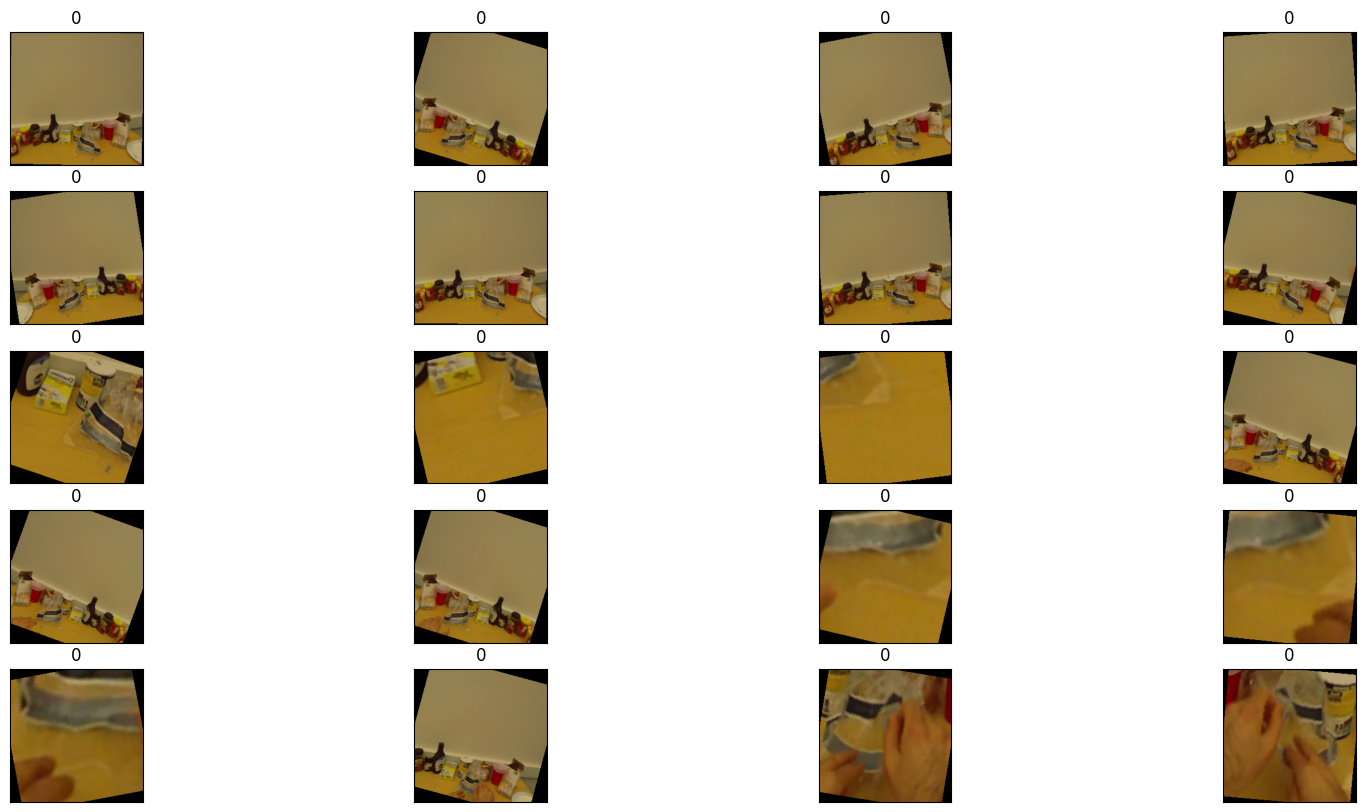

In [11]:
import matplotlib.pyplot as plt

im_numpy = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 10))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(5, 4, idx+1, xticks=[], yticks=[])
    im_convert(images[idx])
    ax.set_title(annotations[idx].item())

In [13]:
len(train_data)

24601

Create CSV for testing aka feature extraction

In [7]:
train = pd.read_csv(os.path.join("csv/train.csv"))
val = pd.read_csv(os.path.join("csv/val.csv"))
all = [train, val]
pd.concat(all)

,frame_path,label
0,S1_Cheese_C1_0000000001.png,0
1,S1_Cheese_C1_0000000002.png,0
2,S1_Cheese_C1_0000000003.png,0
3,S1_Cheese_C1_0000000004.png,0
4,S1_Cheese_C1_0000000005.png,0
...,...,...
6619,S4_Tea_C1_0000001147.png,0
6620,S4_Tea_C1_0000001148.png,0
6621,S4_Tea_C1_0000001149.png,0
6622,S4_Tea_C1_0000001150.png,0


In [14]:
train["frame_path"] = "./csv/train/" + train["frame_path"].astype(str)
train

,frame_path,label
0,./csv/train/S1_Cheese_C1_0000000001.png,0
1,./csv/train/S1_Cheese_C1_0000000002.png,0
2,./csv/train/S1_Cheese_C1_0000000003.png,0
3,./csv/train/S1_Cheese_C1_0000000004.png,0
4,./csv/train/S1_Cheese_C1_0000000005.png,0
...,...,...
24596,./csv/train/S3_Tea_C1_0000001357.png,57
24597,./csv/train/S3_Tea_C1_0000001358.png,57
24598,./csv/train/S3_Tea_C1_0000001359.png,57
24599,./csv/train/S3_Tea_C1_0000001360.png,0


In [31]:
import dataset

train_data = dataset.GTEADataset(mode="train", transform=dataset.img_transforms)
val_data = dataset.GTEADataset(mode="val", transform=dataset.img_transforms_val)


train_loader = dataset.DataLoader(train_data, 64,
                            shuffle=True, num_workers=4) 

val_loader = dataset.DataLoader(val_data, 64,
                            shuffle=True, num_workers=4) 

In [29]:
images, annotations = next(iter(test_loader))
print(images.shape)
print(annotations.shape)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa36e11820>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa36e11820>Traceback (most recent call last):

  File "/home/ubuntu/local/Resnet50/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
  File "/home/ubuntu/local/Resnet50/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()    
Exception ignored in: Exception ignored in: self._shutdown_workers()  File "/home/ubuntu/local/Resnet50/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa36e11820>
      File "/home/ubuntu/local/Resnet50/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():
    
Traceback (most recent call last):
if w

torch.Size([64, 3, 224, 224])
torch.Size([64, 1])


In [16]:
name = ('S1_Cheese_C1_0000000126.png',)
str(name[0])

'S1_Cheese_C1_0000000126.png'

In [19]:
import torch
cc = torch.load("/home/ubuntu/data/video_feature_extractor/i3d_concat/S1_Cheese_C1.pth")
cc.shape

torch.Size([2048, 943])

### Dataset for extracting features

In [1]:
import dataset
from torch.utils.data import Dataset, DataLoader

data = dataset.VideoDataset(
            dataset_dir="/home/ubuntu/data/HAR_datasets/GTEA/png",
            csv_file="/home/ubuntu/data/video_feature_extractor/csv/gtea.csv",
            spatial_transform=dataset.img_transforms_val)

loader = DataLoader(
        data,
        batch_size=1,
        shuffle=False,
        num_workers=1,
    )

images, annotations = next(iter(loader))
print(type(images))
print(type(images))

You are using :  png
path S2_Hotdog_C1
name S2_Hotdog_C1
CLIP  811
path S1_Cheese_C1
name S1_Cheese_C1
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [4]:
images.shape

torch.Size([1, 3, 811, 224, 224])

### Extract try

In [6]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import wandb
import argparse
import dataset 

# resnet = models.resnet18(weights='IMAGENET1K_V1')
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_ftrs = resnet.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
resnet.fc = nn.Linear(num_ftrs, 73)

# Load state dict 
state_dict = torch.load('/home/ubuntu/local/Resnet50/checkpoints/best_model_params_64.pt')
# print("KEYS", state_dict.keys())


# Load state dict into the model
resnet.load_state_dict(state_dict)
# Remove the last fully connected layer
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])

# Set the model to evaluation mode
resnet.eval()

train_data = dataset.GTEADataset(mode="train", transform=dataset.img_transforms)
val_data = dataset.GTEADataset(mode="val", transform=dataset.img_transforms_val)


train_loader = DataLoader(train_data, batch_size=1,
                            shuffle=False, num_workers=1) 

val_loader = DataLoader(val_data, batch_size=1,
                            shuffle=False, num_workers=1) 
# Iterate through your dataset and extract features
total_feats = []
i = 0
for images, labels, name in train_loader:
    while i<5:
        print(i)
        # Forward pass through the model
        features = resnet(images)
        features_np = features.to('cpu').detach().numpy().copy()
        total_feats.append(features_np)
        i+=1
    break
    

0
1
2
3
4


In [13]:
output_array = np.concatenate(total_feats, axis=0)
output_array.squeeze().shape

(5, 2048)

In [14]:
import os
os.path.join("data/gtea", "S1_Cheese_C1", "_", "001.png")

'data/gtea/S1_Cheese_C1/_/001.png'

In [5]:
import dataset
from torch.utils.data import Dataset, DataLoader

data = dataset.VideoFramesDataset(video_path="/home/ubuntu/local/Resnet50/GTEA/train", video="S1_Cheese_C1", png_path="/home/ubuntu/data/HAR_datasets/GTEA/png", transform=dataset.img_transforms_val)

# Create the dataloader
dataloader = DataLoader(data, batch_size=8, shuffle=False, num_workers=4)

In [6]:
frames, path = next(iter(dataloader))
print(type(frames))


<class 'torch.Tensor'>


In [7]:
path

('/home/ubuntu/local/Resnet50/GTEA/train/S1_Cheese_C1_0000000001.png',)

In [6]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import wandb
import argparse
import dataset 

# device = torch.device("cuda:1"if torch.cuda.is_available() else "cpu")
# print("DEVICE = ", device)
# #  resnet = models.resnet18(weights='IMAGENET1K_V1')
# resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# num_ftrs = resnet.fc.in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
# resnet.fc = nn.Linear(num_ftrs, 73)

# # Load state dict 
# state_dict = torch.load('/home/ubuntu/local/Resnet50/checkpoints/best_model_params_64.pt')
# # print("KEYS", state_dict.keys())


# # Load state dict into the model
# resnet.load_state_dict(state_dict)
# # Remove the last fully connected layer
# resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
# resnet.to(device)

# dev = next(resnet.parameters()).device
# print("DEVICE" , dev)

# # Set the model to evaluation mode
# resnet.eval()

In [3]:

data = dataset.VideoFramesDataset(video_path="/home/ubuntu/local/Resnet50/GTEA/train", video="S1_Cheese_C1", png_path="/home/ubuntu/data/HAR_datasets/GTEA/png", transform=dataset.img_transforms_val)

# Create the dataloader
dataloader = DataLoader(data, batch_size=1, shuffle=True, num_workers=4)


In [7]:
resnet.device

AttributeError: 'Sequential' object has no attribute 'device'

In [7]:
device = torch.device("cuda:1"if torch.cuda.is_available() else "cpu")
#  resnet = models.resnet18(weights='IMAGENET1K_V1')
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_ftrs = resnet.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
resnet.fc = nn.Linear(num_ftrs, 73)

# Load state dict 
state_dict = torch.load('/home/ubuntu/local/Resnet50/checkpoints/best_model_params_64.pt')


# Load state dict into the model
resnet.load_state_dict(state_dict)
# Remove the last fully connected layer
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet.to(device)

dev = next(resnet.parameters()).device
print("DEV" , dev)

# Set the model to evaluation mode
resnet.eval()

# Iterate through your dataset and extract features
total_feats = []
i = 0
for frame_batch in val_loader:
    
    # Forward pass through the model
    for frames in frame_batch[0].squeeze(0):
        while i<10:
            print(i)
            frames = frames.to(device)
            print(frames.device)
            features = resnet(frames.unsqueeze(0))
            features = features.view(2048)
            # print(features.shape)

            # features_np = features.to('cpu').detach().numpy().copy()
            total_feats.append(features)
            i+=1
        break
final_features = torch.stack(total_feats, dim=0)        

    
#     # Process or store the extracted features as needed
#     np.save("/home/ubuntu/local/Resnet50/features/resnet50/S1_Cheese_C1.npy", features_np)
print(final_features.shape)


DEV cuda:1
0
cuda:1
1
cuda:1
2
cuda:1
3
cuda:1
4
cuda:1
5
cuda:1
6
cuda:1
7
cuda:1
8
cuda:1
9
cuda:1
torch.Size([10, 2048])


In [19]:
for frame_batch in dataloader:
    print(frame_batch[0].shape)

torch.Size([1, 3, 224, 224])


In [20]:
val_data = dataset.GTEADataset(mode="val", transform=dataset.img_transforms_val)

val_loader = dataset.DataLoader(val_data, 64,
                            shuffle=False, num_workers=4) 

image, label, name = next(iter(val_loader))

In [28]:
image.shape

torch.Size([64, 3, 224, 224])

In [10]:
import dataset
val_data = dataset.VideoFramesDatasetNew(video_path="/home/ubuntu/local/Resnet50/GTEA/train", video="S1_Cheese_C1", png_path="/home/ubuntu/data/HAR_datasets/GTEA/png", transform=dataset.img_transforms_val)

val_loader = dataset.DataLoader(val_data, 64,
                            shuffle=False, num_workers=4) 

image, frame_path = next(iter(val_loader))

In [23]:
for frame_batch in val_loader:
    print(frame_batch[0].shape)


torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([47, 3, 224, 224])


In [16]:
a = torch.load("/home/ubuntu/local/Resnet50/features/resnet50/S1_Cheese_C1_batch_1.pth")
b = torch.load("/home/ubuntu/local/Resnet50/features/resnet50/S1_Cheese_C1_batch_2.pth")
torch.cat((a,b), dim=0).shape

torch.Size([128, 2048])

In [20]:
video = "S1_Cheese_C1"
batch_feats = sorted(os.listdir(os.path.join("/home/ubuntu/local/Resnet50/features/resnet50", video)))
final = torch.empty(0,2048)

for batch in batch_feats:
    feats = torch.load("/home/ubuntu/local/Resnet50/features/resnet50/S1_Cheese_C1/"+batch)
    final = torch.cat((final, feats), dim=0)
final.shape


torch.Size([943, 2048])

In [10]:
torch.load("/home/ubuntu/local/Resnet50/features/weighted_resnet/hand_feats/S1_CofHoney_C1.pth").shape

torch.Size([1235, 2048])

In [39]:
torch.load("/home/ubuntu/data/video_feature_extractor/i3d_concat/S1_Cheese_C1.pth").shape

torch.Size([2048, 943])

In [6]:
import torch
torch.load("/home/ubuntu/data/video_feature_extractor/i3d_concat//S1_Cheese_C1.pth").shape

torch.Size([2048, 943])